# Airline Delay Binary Classification Analysis

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

http://stat-computing.org/dataexpo/2009/the-data.html

Items to discuss:
1. Creating dummy variables for categorical variables of interest 
2. Other adjustments to make analysis more computationally efficient/practical 
3. Feature selection best practices -- identifying optimal number of features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import cross_val_score
from sklearn import grid_search
import seaborn as sns
from sklearn.preprocessing import normalize

## Data preparation and exploration

In [3]:
# Read in data
df = pd.read_csv('airline-2008.csv')

In [5]:
# Our research question is only interested in flights arriving late, so we'll remove cancelled flights
df = df.loc[df['Cancelled'] == 0]

# We'll delete redundant/intuitively irrelevant variables 
df = df.drop(['Year','CRSDepTime','ArrTime','CRSArrTime','CRSElapsedTime','CancellationCode',
             'Origin','Dest','UniqueCarrier','TailNum','Cancelled','Diverted','ActualElapsedTime','AirTime'],1)

In [6]:
# Create target variable; turn into binary classification problem 
df['delayed'] = np.where(df['ArrDelay'] > 30,1,0)

# Remove arrival delay variable from featureset 
df = df.drop('ArrDelay',1)

In [7]:
# Evaluate data types of data set to make sure they're appropriate for our models
df.dtypes

Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
FlightNum              int64
DepDelay             float64
Distance               int64
TaxiIn               float64
TaxiOut              float64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
delayed                int64
dtype: object

In [8]:
# Evaluate for NULL values
df.isnull().sum()

Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
FlightNum                  0
DepDelay                   0
Distance                   0
TaxiIn                 14215
TaxiOut                    0
CarrierDelay         5347559
WeatherDelay         5347559
NASDelay             5347559
SecurityDelay        5347559
LateAircraftDelay    5347559
delayed                    0
dtype: int64

In [18]:
# We'll assume that data measuring time in minutes with NaN values are = 0
cols = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
        'LateAircraftDelay']

for i in cols:
    df[i] = df[i].fillna(0)

In [21]:
# Drop remaining observations with missing values
df = df.dropna()

In [22]:
# Down sample to balance class 
from sklearn.preprocessing import normalize
from imblearn.under_sampling import RandomUnderSampler
usampler = RandomUnderSampler()

X_orig = df.drop('delayed',1)
y_orig = df['delayed']

X_sm, y_sm = usampler.fit_sample(X_orig,y_orig)

sm_features = pd.DataFrame(data=X_sm,columns=X_orig.columns)
sm_target = pd.DataFrame(data=y_sm,columns=['delayed'])

# Put data set backtogether
frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

# Assign undersampled data back into X and y; normalize parameters 
X = normalize(sm_features)
y = sm_target.values.ravel()

In [23]:
#Verify that classes are now balanced
sm_data['delayed'].value_counts()

1    901398
0    901398
Name: delayed, dtype: int64

In [24]:
# Do a 70/30 test/train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

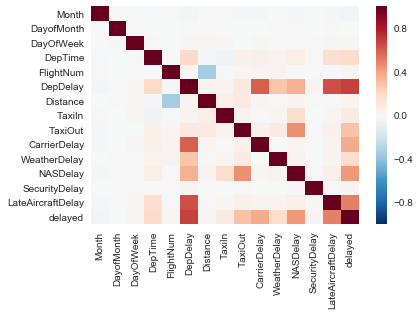

In [25]:
# Create heatmap to check for any issues with collinearity
sns.heatmap(df.corr())

X_train = pd.DataFrame(data=X_train,columns=X_orig.columns)
y_train = pd.DataFrame(data=y_train,columns=['delayed'])

X_test = pd.DataFrame(data=X_train,columns=X_orig.columns)
y_test = pd.DataFrame(data=y_train,columns=['delayed'])

## Feature Selection

### PCA

In [26]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

pca = PCA(n_components=8)

# Assign features and target variable to 'X' and 'Y' respectively
X_scaled = preprocessing.scale(X_train)

X_pca = pca.fit_transform(X_scaled)

[ 0.2594771   0.12956879  0.09812108  0.07457266  0.07164421  0.07138682
  0.06917753  0.05618894]


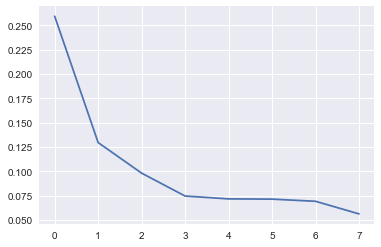

In [27]:
# Evaluate explained variance ratio -- it appears that the first component explains
# most of the data set. 
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)

In [28]:

# The first principal component explains the variance of a little over 9 of 
# our features
pca.explained_variance_

array([ 3.63268223,  1.81396447,  1.37369624,  1.04401807,  1.00301977,
        0.99941634,  0.96848624,  0.78664576])

In [29]:
np.sum(pca.explained_variance_ratio_)

0.83013713678536005

### F Class

### Mutual Information

## Modeling 

In [30]:
#Initialize lists to store model performance
scores = []
model = []
run_time = []

### Preliminary run: all data

#### Naive Bayes

In [31]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

# Initialize model
bnb = BernoulliNB()

# Initialize start time
start_time = time.time()

# Fit model
bnb.fit(X_train,y_train)

# Store training duration
t = (time.time() - start_time)

#Print training duration
print("--- %s seconds ---" % t)

# Append training duration to list for later analysis
run_time.append(t)


nb_scores = cross_val_score(bnb,X_test,y_test,cv=5)

nb_score = np.mean(nb_scores)
scores.append(nb_score)
model.append("Naive Bayes")
print("Mean score:", nb_score)

y_pred = bnb.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.6408779621124268 seconds ---
Mean score: 0.931214276928


Predicted,0,1,All
True,,,
0,249055,21526,270581
1,15676,254582,270258
All,264731,276108,540839


#### Decision Tree

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
parameters = {'criterion':('gini','entropy'),'max_depth':list(range(1,11,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(decision_tree, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

decision_tree = tree.DecisionTreeClassifier(**gs.best_params_)

start_time = time.time()
decision_tree.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


decision_tree_scores = cross_val_score(decision_tree, X_test, y_test, cv=5)


decision_tree_score = np.mean(decision_tree_scores)
scores.append(decision_tree_score)
model.append("Decision Tree")
print("Mean score:", decision_tree_score)
print("Optimal parameters:", gs.best_params_)

y_pred = decision_tree.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

#### Random Forest

In [ ]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()

parameters = {'n_estimators':list(range(1,100,10)),'max_depth':list(range(1,10,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(rfc, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

rfc = ensemble.RandomForestClassifier(**gs.best_params_)

start_time = time.time()
rfc.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


rfc_scores = cross_val_score(rfc,X_test,y_test,cv=5)


rfc_score = np.mean(rfc_scores)
scores.append(rfc_score)
model.append("Random Forest")
print("Mean score:", rfc_score)
print("Optimal parameters:", gs.best_params_)

y_pred = rfc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameters = {'n_neighbors':list(range(1,50,1)),'weights':('uniform','distance'),'algorithm':('auto','ball_tree','kd_tree','brute')}
gs = grid_search.GridSearchCV(knn, parameters,cv= 3,scoring="accuracy")
gs.fit(normalize(X_train),y_train)

knn = KNeighborsClassifier(**gs.best_params_)

start_time = time.time()
knn.fit(normalize(X_train), y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


knn_scores = cross_val_score(knn, normalize(X_test), y_test, cv=5)

knn_score = np.mean(knn_scores)
scores.append(knn_score)
model.append("KNN")
print("Mean score:", knn_score)
print("Optimal parameters:", gs.best_params_)

y_pred = knn.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

start_time=time.time()
lr.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

lr_scores = cross_val_score(lr,X_test,y_test,cv=5)

lr_score = np.mean(lr_scores)
scores.append(lr_score)
model.append("Logistic Regression")
print(lr_score)

y_pred = lr.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

#### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=1000000)

start_time=time.time()
svc.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


svc_scores = cross_val_score(svc,X_test,y_test,cv=5)


svc_score = np.mean(svc_scores)
scores.append(svc_score)
model.append("SVC")
print(svc_score)

y_pred = svc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

#### Boosting

In [ ]:
from sklearn import grid_search

gradient_boost = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':list(range(1,501,50)),'max_depth':list(range(1,11,2)),'loss':('exponential','deviance')}
gs = grid_search.GridSearchCV(gradient_boost, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

start_time = time.time()
clf.fit(X_train, y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)
clf_scores = cross_val_score(clf,X_test,y_test,cv=5)

clf_score = np.mean(clf_scores)
scores.append(clf_score)
model.append("Boosting")
print(clf_score)

y_pred = clf.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

## Evaluation

In [ ]:
results = pd.DataFrame()
results['scores'] = scores
results['model'] = model
results['run_time'] = run_time

results = results.sort_values(by=['scores'])

In [ ]:
sns.barplot(x=results['scores'],y=results['model'])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Performance")

In [ ]:
sns.barplot(x=results['run_time'],y=results['model'])
plt.xlabel("Run time")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Run time")